In [1]:
import os
from itertools import product

from bdpy.dataform import Features, DecodedFeatures
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [2]:
# Load data
stimulus_images = Features('data/stimulus/test')
predicted_contrasts = DecodedFeatures('data/prediction/recon_smlr_100voxelselection')

Found 480 decoded features in data/prediction/recon_smlr_100voxelselection


In [3]:
# Reconstruction functions
def reconstruction(df: DecodedFeatures, subject: str = 's1', roi: str = 'V1', image_size=(10, 10)):

    bases = [(1, 1), (1, 2), (2, 1), (2, 2)]
    labels = df.labels

    recon_images_list = []
    
    w = 1  # FIXME: combination coefficient is not implemented yet
    
    for label in labels:
        recon_image = np.zeros(image_size)
        for basis in bases:
            pred_c = df.get(subject=subject, roi=roi, layer=f"{basis[0]}x{basis[1]}", label=label)[0]  # Drop batch dim
            basis_images = make_basis_images(basis, image_size)
            for i, j in product(range(pred_c.shape[0]), range(pred_c.shape[1])):
                recon_image += w * basis_images[i, j] * pred_c[i, j]

        recon_images_list.append(recon_image)
    
    recon_images = np.stack(recon_images_list, axis=0)
            
    return recon_images, labels


def make_basis_images(basis_size=(1, 1), image_size=(10, 10)):

    nh = image_size[0] - basis_size[0] + 1
    nw = image_size[1] - basis_size[1] + 1

    basis_images = np.zeros((nh, nw, *image_size))
    
    for i, j in product(range(nh), range(nw)):
        basis_img = np.zeros((image_size[0] + 1, image_size[1] + 1))
        basis_img[i:i + basis_size[0], j:j + basis_size[1]] = 1
        basis_img = basis_img[:image_size[0], :image_size[1]]
        basis_images[i, j, :, :] = basis_img

    return basis_images

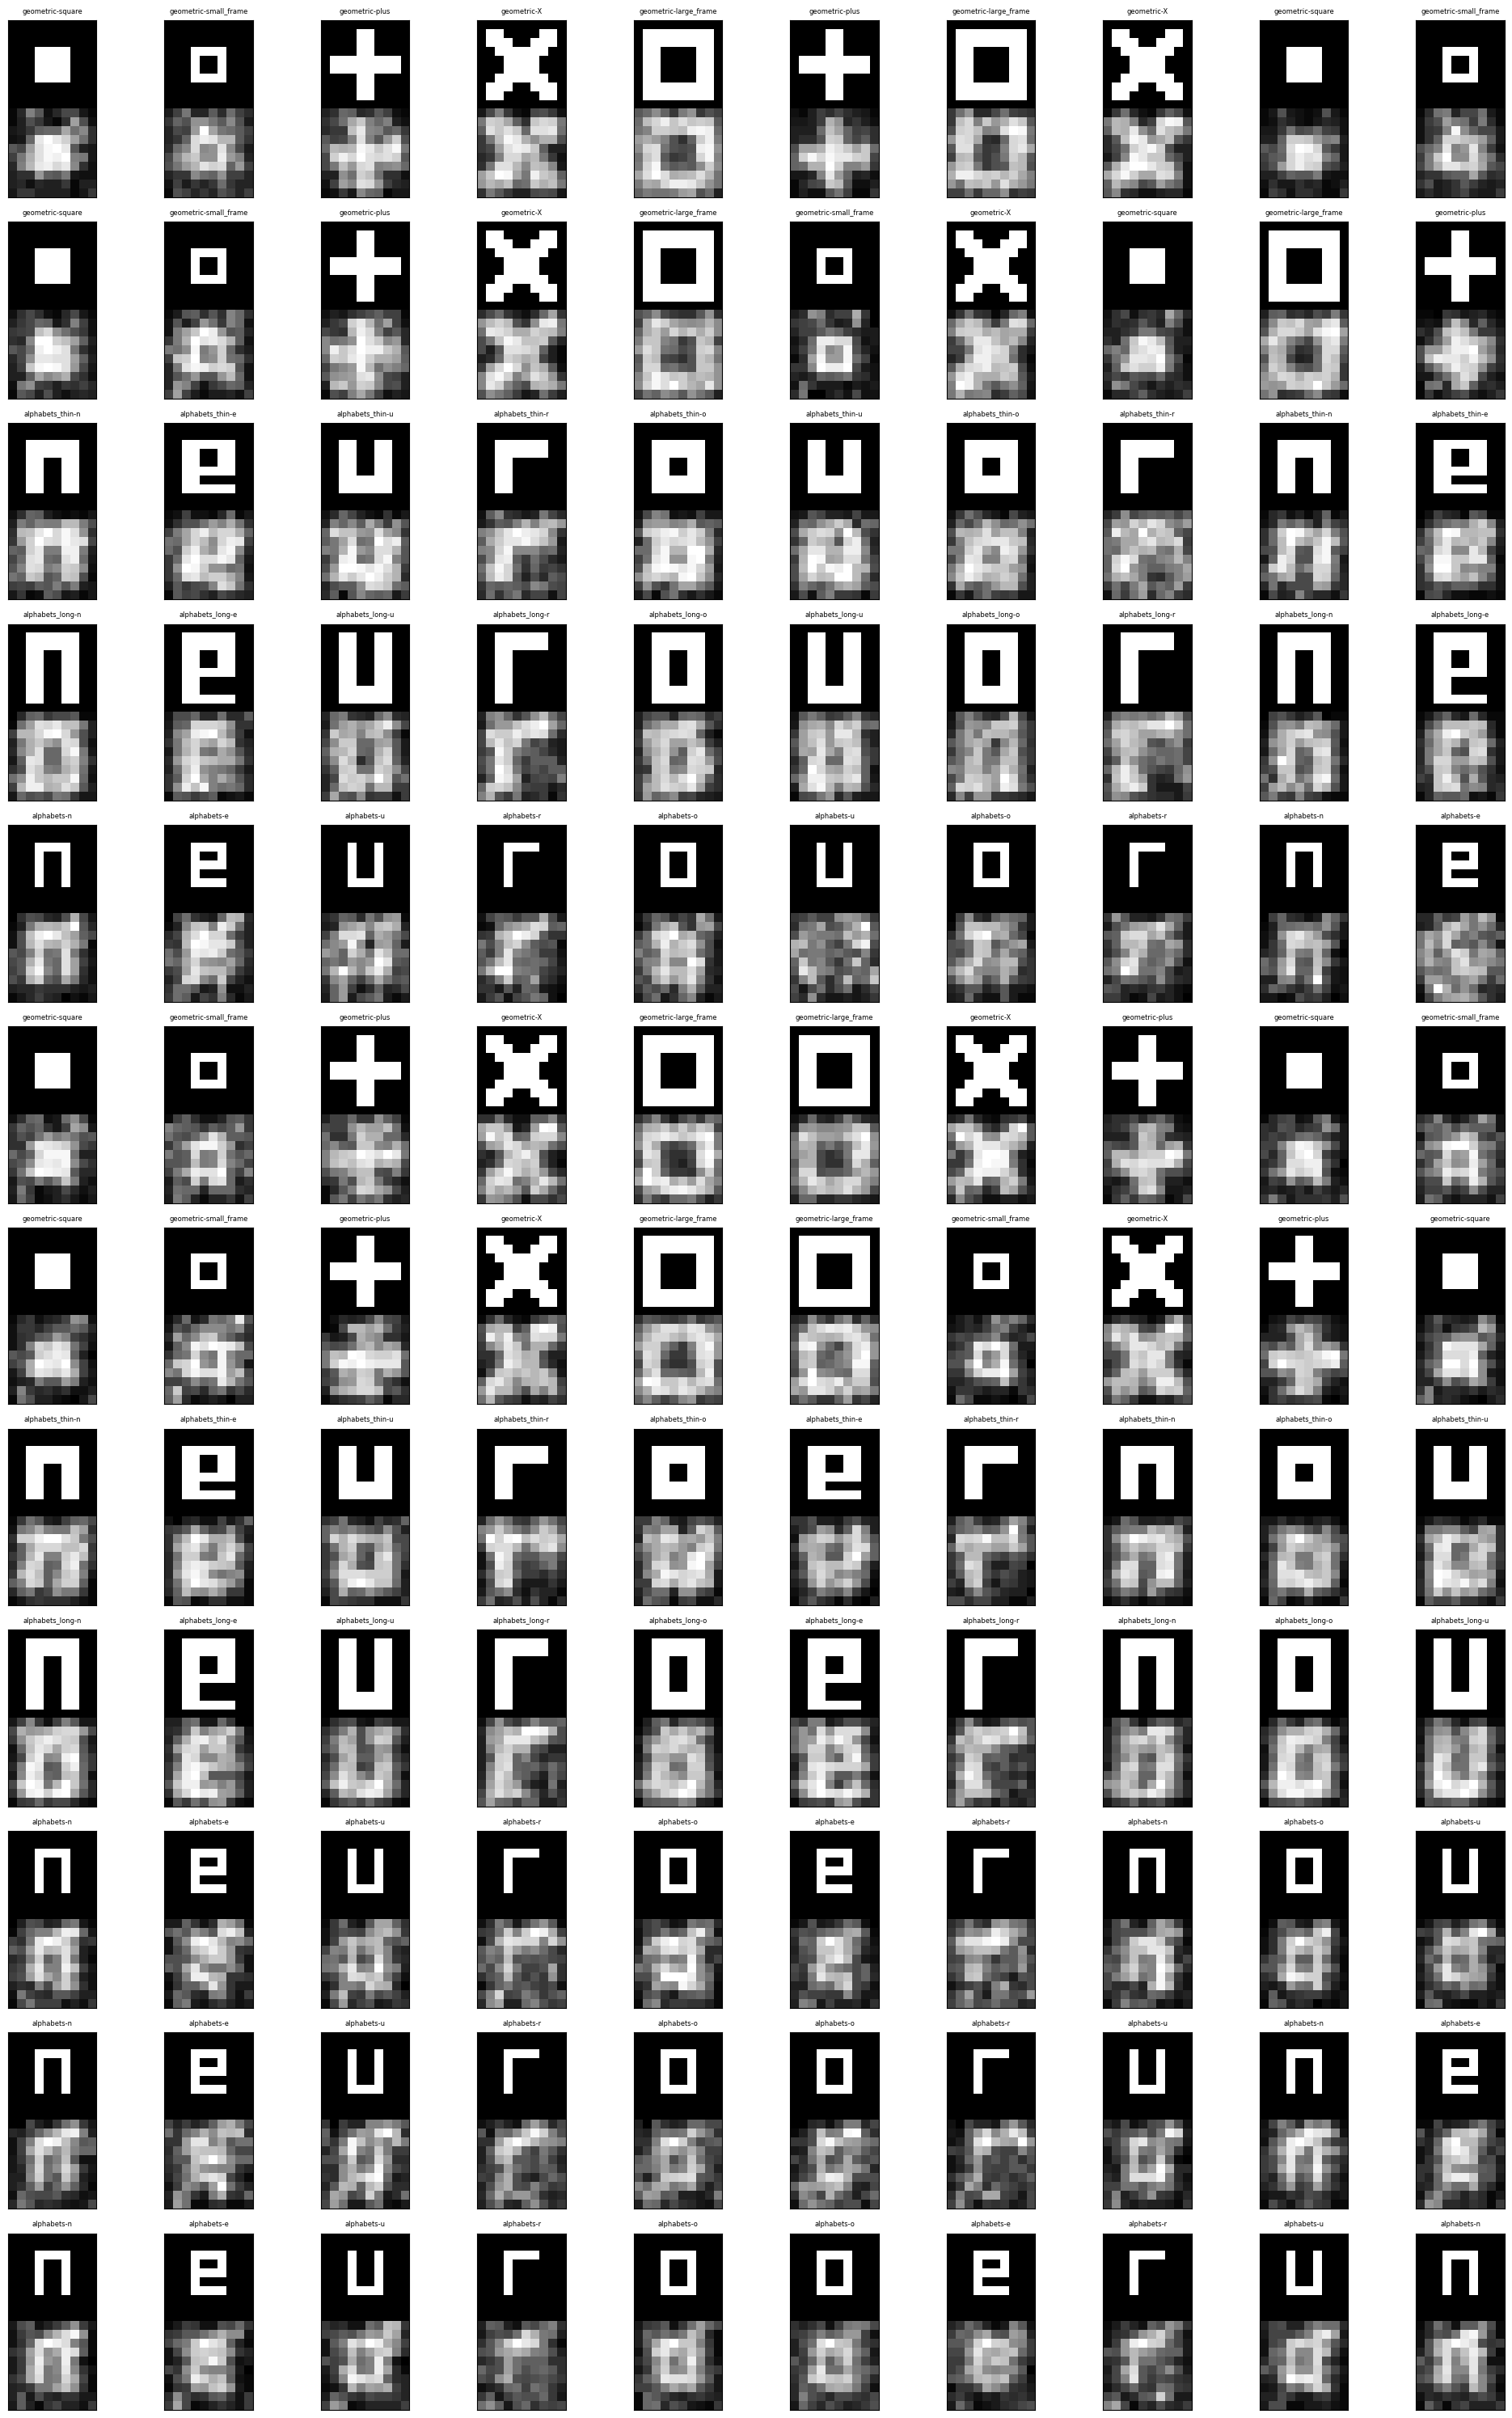

In [4]:
subjects = predicted_contrasts.subjects
rois = predicted_contrasts.rois

for subject, roi in product(subjects, rois):

    recon_images, labels = reconstruction(predicted_contrasts, subject=subject, roi=roi)

    fig = plt.figure(figsize=(20, 30))
    axes = fig.subplots(12, 10)
    axes = axes.flatten()
        
    for i, label in enumerate(labels):
        stim_label = '-'.join(label.split('-')[1:])

        stim_img = stimulus_images.get(layer='1x1', label=stim_label)[0]
        recon_img = recon_images[i]
        recon_img /= np.max(recon_img)
        
        axes[i].imshow(np.vstack([stim_img, recon_img]), cmap='gray')
        axes[i].set_title(stim_label, fontsize=6)
        axes[i].tick_params(bottom=False, left=False, right=False, top=False, labelbottom=False, labelleft=False, labelright=False, labeltop=False)

    fig.tight_layout()
    fig.savefig(f"figures/recon_{subject}_{roi}.jpg", dpi=300)